# This Jupyter Notebook contains the results of various supervised machine learning models trained on the cleaned OSMI mental health dataset.

## Warnings are suppressed for concise output.

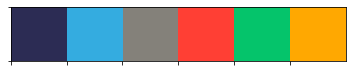

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
          
flatUI = ["#2c2c54", "#34ace0", "#84817a", "#ff3f34", "#05c46b", "#ffa801"]
sns.set_palette(flatUI)
sns.palplot(sns.color_palette())
plt.show()

def showFigure(fig, x=16, y=4):
    fig = plt.gcf()
    fig.set_size_inches(x, y)
    plt.show()

## The dataset is cleaned for any nan values. The nan values are replaced with some default values depending on the type of data provided.
### The features X are trained against the final outcome y.

In [2]:
import numpy as np
import pandas as pd  # data processing, CSV file I/O

survey = pd.read_csv('cleanedDatasets/OSMIcleaned.csv')

y = survey['Sought Treatment']

def bestFill(datset):
    for feature in survey:
        if survey[feature].dtype == np.int64:
             print('int64, not available = -1 : ', feature)
             survey[feature] = pd.to_numeric(survey[feature], errors='coerce').astype(int)
             survey[feature].fillna(0, inplace=True)
 
        elif survey[feature].dtype == np.float64:
             print('float64, not available = -1 : ', feature)
             survey[feature].fillna(0, inplace=True)
             survey[feature] = pd.to_numeric(survey[feature], errors='coerce').astype(float)

        elif survey[feature].dtype == np.object:
             print('object, not available = NaN : ', feature)
             survey[feature].fillna('NaN', inplace=True)
            
bestFill(survey)        

features= ['Family History of Mental Illness',
        'Company Size', 
        'year',
        'Age', 
        'Age-Group', 
        'Gender', 
        'Prefer Anonymity',
        'Rate Reaction to Problems', 
        'Negative Consequences',
        'Access to information', 
        'Diagnosis',
        'Insurance',
        'Discuss Mental Health Problems', 
        'Responsible Employer', 
        'Disorder',
        'Primarily a Tech Employer']   

X = survey[features]

object, not available = NaN :  Family History of Mental Illness
object, not available = NaN :  Company Size
int64, not available = -1 :  year
int64, not available = -1 :  Age
object, not available = NaN :  Age-Group
object, not available = NaN :  Gender
int64, not available = -1 :  Sought Treatment
object, not available = NaN :  Describe Past Experience
float64, not available = -1 :  Prefer Anonymity
object, not available = NaN :  Rate Reaction to Problems
object, not available = NaN :  Negative Consequences
object, not available = NaN :  Location
object, not available = NaN :  Access to information
float64, not available = -1 :  Insurance
object, not available = NaN :  Diagnosis
object, not available = NaN :  Discuss Mental Health Problems
object, not available = NaN :  Responsible Employer
object, not available = NaN :  Disorder Notes
int64, not available = -1 :  Disorder
float64, not available = -1 :  Primarily a Tech Employer


### The features are split into numerical features and categorical features. The numerical features are scaled using StandardScaler, whereas the categorical features are encoded using OneHotEncoder. The dataset is split 60:40, that is 60% of the data is used in training and 40% of the data is used for testing the trained model. Finally a dictionary is maintained of accuracy attained from each of the models.

In [3]:
numerical_features = (X.dtypes == 'float') | (X.dtypes == 'int')
categorical_features = ~numerical_features

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
preprocess = make_column_transformer(
    (StandardScaler(), numerical_features),
    (OneHotEncoder(), categorical_features), remainder="drop", n_jobs= -1, verbose = True
)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.40, random_state=1)

# Accuracy of each model
models = {}

### In order to evaluate the outcomes of each model, a function is defined which shows and plots some characteristics of the model in view. 

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn import metrics
def evaluateModel(model, yPredClass, plot=False):
    # Classification Accuracy: Overall, how often is the classifier correct?
    accuracy = metrics.accuracy_score(Y_test, yPredClass)
    print('Classification Accuracy:', accuracy*100)
    
    # Comparing the true and predicted response values
    print('\nTrue:', Y_test.values[0:25])
    print('Pred:', yPredClass[0:25])
   
    # Metrics computed from a confusion matrix
    confusion = metrics.confusion_matrix(Y_test, yPredClass)
    # [row, column]
    TP = confusion[1, 1]   # True Positive
    TN = confusion[0, 0]   # True Negative
    FP = confusion[0, 1]   # False Positive
    FN = confusion[1, 0]   # False Negative
    
    # False Positive Rate: When the actual value is negative, how often is the prediction incorrect?
    false_positive_rate = FP / float(FP+TN)
    print('\nFalse Positive Rate:', false_positive_rate)

    # Precision: When a positive value is predicted, how often is the prediction correct?
    print('Precision:', metrics.precision_score(Y_test, yPredClass))

    # IMPORTANT: first argument is true values, second argument is predicted probabilities
    print('AUC Score:', metrics.roc_auc_score(Y_test, yPredClass))
    # store the predicted probabilities for class 1
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    # visualize Confusion Matrix

    fig = sns.heatmap(confusion, annot=True, fmt="d")
    bottom, top = fig.get_ylim()
    fig.set_ylim(bottom + 0.5, top - 0.5)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # histogram of predicted probabilities
    if plot:
        plt.rcParams['font.size'] = 12
        plt.hist(y_pred_prob, bins=4)
        # x-axis limit from 0 to 1
        plt.xlim(0, 1)
        plt.title('Histogram of predicted probabilities')
        plt.xlabel('Predicted probability of treatment')
        plt.ylabel('Frequency')

    # AUC is the percentage of the ROC plot that is underneath the curve
    # Higher value = better classifier
    roc_auc = metrics.roc_auc_score(Y_test, y_pred_prob)

    # roc_curve returns 3 objects fpr, tpr, thresholds
    # fpr: false positive rate
    # tpr: true positive rate
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_pred_prob)
    if plot:
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('ROC curve for treatment classifier')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.show()

    return accuracy

## Some common supervised learning algorithms are trained on the dataset and outcomes are shown.

## [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

############### Logistic Regression ###############
Classification Accuracy: 79.37944408532644

True: [1 1 1 0 0 0 1 1 1 1 1 0 1 0 0 0 1 1 0 0 1 1 0 1 0]
Pred: [1 1 1 0 1 1 0 1 1 1 0 0 1 0 0 0 1 1 0 0 1 0 0 1 0]

False Positive Rate: 0.2087087087087087
Precision: 0.8345238095238096
AUC Score: 0.7934890054640338


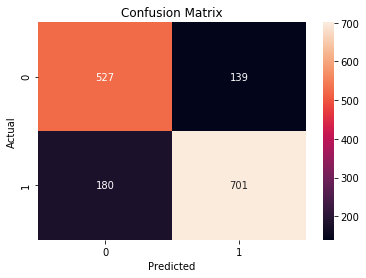

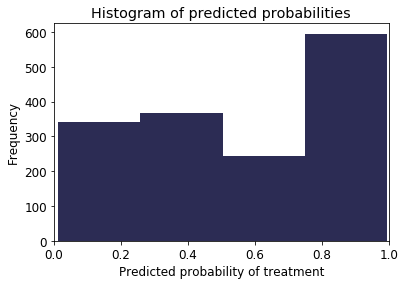

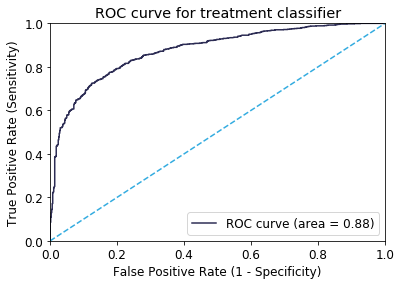

In [5]:
from sklearn.linear_model import LogisticRegression
def logisticRegression():
    # train a logistic regression model on the training set
    modelLogisticRegression = make_pipeline(preprocess, LogisticRegression(solver='liblinear', multi_class='ovr'))
    modelLogisticRegression.fit(X_train, Y_train)

    # make class predictions for the testing set
    y_pred_class = modelLogisticRegression.predict(X_test)

    print('############### Logistic Regression ###############')

    accuracy_score = evaluateModel(modelLogisticRegression, y_pred_class, True)

    models['Logistic Regression'] = accuracy_score * 100
    
logisticRegression()

### [K-Neighbors Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

########### K-Neighbors Classifier ###############
Classification Accuracy: 76.47058823529412

True: [1 1 1 0 0 0 1 1 1 1 1 0 1 0 0 0 1 1 0 0 1 1 0 1 0]
Pred: [1 1 1 0 1 1 0 1 1 1 0 1 1 0 0 0 1 1 0 0 1 0 0 1 0]

False Positive Rate: 0.2747747747747748
Precision: 0.7927519818799547
AUC Score: 0.7598884355411029


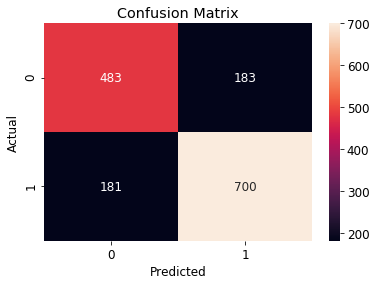

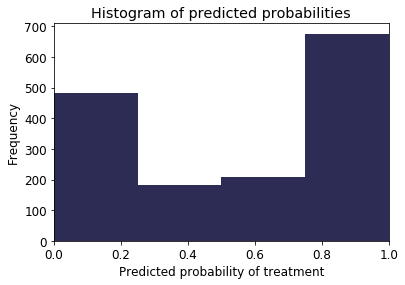

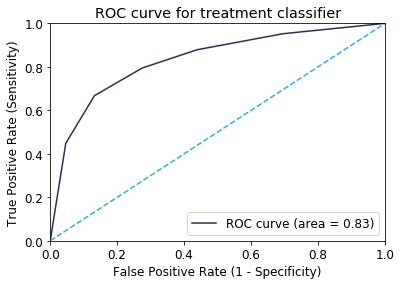

In [6]:
from sklearn.neighbors import KNeighborsClassifier
def kNNClassifier():
    modelKNN = make_pipeline(preprocess, KNeighborsClassifier())
    modelKNN.fit(X_train, Y_train)

    # make class predictions for the testing set
    y_pred_class = modelKNN.predict(X_test)

    print('########### K-Neighbors Classifier ###############')

    accuracy_score = evaluateModel(modelKNN, y_pred_class, True)

    # Data for final graph
    models['K-Neighbors Classifier'] = accuracy_score * 100

kNNClassifier()

## [Decision Tree Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

########### Decision Tree Classifier ###############
Classification Accuracy: 73.69101486748546

True: [1 1 1 0 0 0 1 1 1 1 1 0 1 0 0 0 1 1 0 0 1 1 0 1 0]
Pred: [1 1 1 0 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 0 1 0 0 1 0]

False Positive Rate: 0.29429429429429427
Precision: 0.7736720554272517
AUC Score: 0.7331025690844079


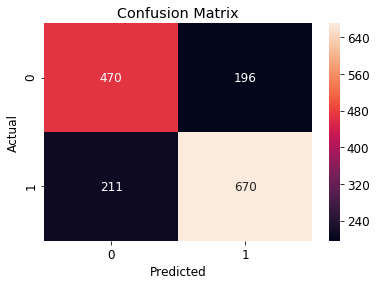

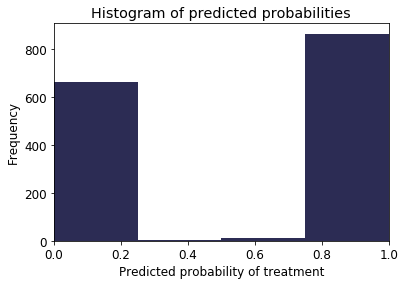

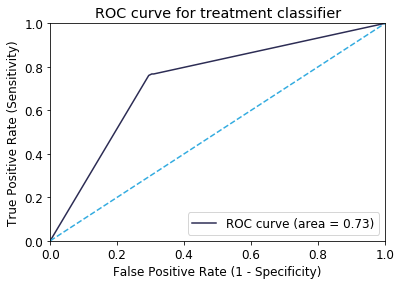

In [7]:
from sklearn.tree import DecisionTreeClassifier
def decisionTreeClassifier():
    # train a logistic regression model on the training set
    modelDecisionTreeClassifier = make_pipeline(preprocess, DecisionTreeClassifier())
    modelDecisionTreeClassifier.fit(X_train, Y_train)

    # make class predictions for the testing set
    y_pred_class = modelDecisionTreeClassifier.predict(X_test)

    print('########### Decision Tree Classifier ###############')

    accuracy_score = evaluateModel(modelDecisionTreeClassifier, y_pred_class, True)

    models['Decision Tree Classifier'] = accuracy_score * 100
    
decisionTreeClassifier()

## [Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)

########### Gaussian Naive Bayes ###############
Classification Accuracy: 68.45507433742728

True: [1 1 1 0 0 0 1 1 1 1 1 0 1 0 0 0 1 1 0 0 1 1 0 1 0]
Pred: [1 1 1 0 0 1 0 1 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 1 0]

False Positive Rate: 0.02702702702702703
Precision: 0.958041958041958
AUC Score: 0.7197441482345002


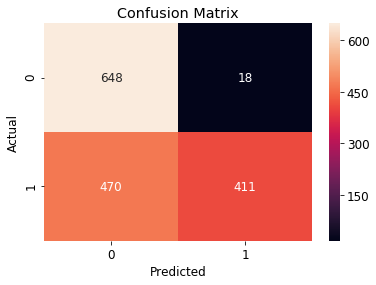

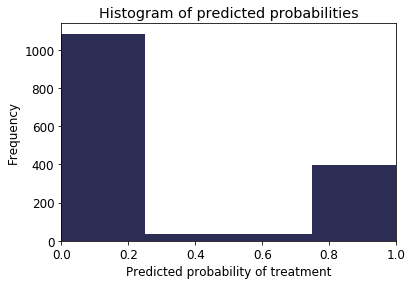

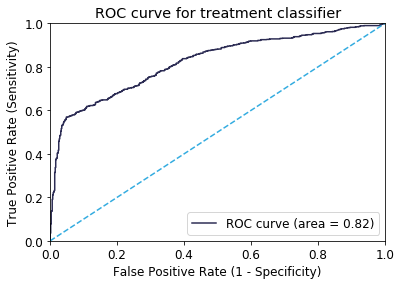

In [8]:
from sklearn.naive_bayes import GaussianNB
def gaussianNBClassifier():
    # train a logistic regression model on the training set
    modelGaussianNB = make_pipeline(preprocess, GaussianNB())
    modelGaussianNB.fit(X_train, Y_train)

    # make class predictions for the testing set
    y_pred_class = modelGaussianNB.predict(X_test)

    print('########### Gaussian Naive Bayes ###############')

    accuracy_score = evaluateModel(modelGaussianNB, y_pred_class, True)

    models['Gaussian Naive Bayes'] = accuracy_score * 100
    
gaussianNBClassifier()

## [C-Support Vector Classification](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

########### C-Support Vector Classification. ###############
Classification Accuracy: 78.99159663865547

True: [1 1 1 0 0 0 1 1 1 1 1 0 1 0 0 0 1 1 0 0 1 1 0 1 0]
Pred: [1 1 1 0 1 1 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 0 0 1 1]

False Positive Rate: 0.20270270270270271
Precision: 0.8365617433414043
AUC Score: 0.7908166395680584


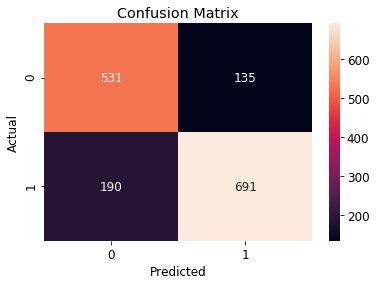

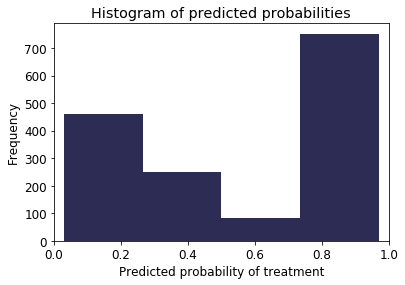

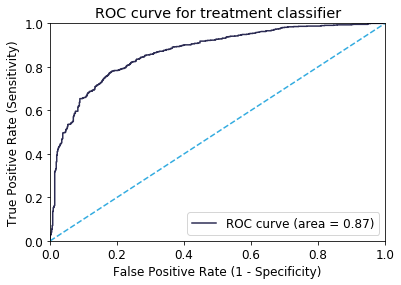

In [9]:
from sklearn.svm import SVC
def SVMClassifier():
    # train a logistic regression model on the training set
    modelSVM = make_pipeline(preprocess, SVC(gamma='auto', probability=True))
    modelSVM.fit(X_train, Y_train)

    # make class predictions for the testing set
    y_pred_class = modelSVM.predict(X_test)

    print('########### C-Support Vector Classification. ###############')

    accuracy_score = evaluateModel(modelSVM, y_pred_class, True)

    models['C-Support Vector Classification'] = accuracy_score * 100
    
SVMClassifier()

## A summary of accuracy scores for varioius models.

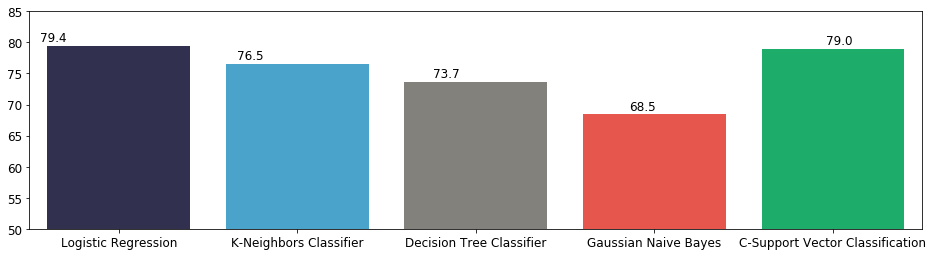

In [10]:
accuracyScores = pd.Series(models)
fig = sns.barplot(x=accuracyScores.index, y=accuracyScores.values)
plt.ylim([50.0, 85.0])
for p in fig.patches:
        fig.annotate(str(round(p.get_height(), 1)), (p.get_x() * 1.1, p.get_height() * 1.01))
showFigure(fig)